In [1]:
import pandas as pd
import numpy as np

In [2]:
# Important Global Values
proteinCodes = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
nucleotides = ["A", "C", "T", "G"]

# Helpful Functions

# gets the probability of an observation obs
# occuring from a distribution, dist
def getP(obs, dist):
  return sum(1 for x in dist if x == obs) / len(dist)

def myLog(x, base = 0.00000000001):
  if x == 0: x = base # to make non-zero
  return np.log(x)

# Generates a random sequence using specified codes of length l
def generateSequence(code, l):
  out = ""
  for i in range(l):
    out = out + np.random.choice(code)
  return out

In [14]:
# This class lets us store an HMM
# It contains HMMState objects that make up the  HMM
# We can generate samples from it and find the most likely sequence
class profileHMM:
  # Initializes the HMM
  def __init__(self, seqType):
    self.seqType = seqType
    if seqType == "AA": self.codes = proteinCodes
    elif seqType == "NA": self.codes = nucleotides

    self.initial_tMat = None

    self.mStates = [] # List of match states

    self.iState = None # The global insertion state
    self.iSizes = None # Distribution of insertion sizes

    self.dState = None
    self.dSizes = None # Distribution of deletion sizes

  def setInitial_tMat(self, tProbs):
    self.initial_tMat = pd.DataFrame({"State": ["Match", "Insert", "Delete"], "Prob": tProbs})

  # Adds match states to the existing HMM
  def add_mState(self, sProbs, tProbs):
    mHMMState = HMMState(sProbs, tProbs, self.codes)
    self.mStates.append(mHMMState)

  # Sets the global insertion state to the HMM
  # We use a global insertion state because it
  # simplifies insertions
  def set_insertionInfo(self, sProbs, tProbs, iSizes):
    iHMMState = HMMState(sProbs, tProbs, self.codes)
    self.iState = iHMMState
    self.iSizes = iSizes

  # Sets the global deletion state info.
  # We use arbitrary state probabilities, because a deletion always
  # removes codes and so we don't need to generate random codes.
  def set_deletionInfo(self, tProbs, dSizes):
    dHMMState = HMMState(np.repeat(0.05, len(self.codes)).tolist(), tProbs, self.codes)
    self.dState = dHMMState
    self.dSizes = dSizes

  # Randomly generates a sequence from the existing HMM
  def sample(self, showDeletes):
    # Sets the deletion character
    deleteChar = ""
    if showDeletes: deleteChar = "-"

    # Tracks the sequence as it iterates
    out_seq = ""

    mStateIDX = 0

    firstState = np.random.choice(a = self.initial_tMat["State"], size = 1, p = self.initial_tMat["Prob"])

    # Checking for an initial Deletion State
    while firstState == "Delete":
      # If we are, determine the size of the deletion
      deletionAmount = np.random.choice(self.dSizes)
      out_seq = out_seq + deleteChar
      deletionAmount = deletionAmount - 1
      # If this deletion is longer than 1
      # we need to skip the next mStates too
      while deletionAmount > 0:
        # Adds the deletion char to the sequence
        out_seq = out_seq + deleteChar
        deletionAmount = deletionAmount - 1
        # Skips the next mState
        mStateIDX = mStateIDX + 1
      firstState = self.dState.forward()[1]

    # Checking for an initial Insertion State
    while firstState == "Insert":
      insertionAmount = np.random.choice(self.iSizes)
      while insertionAmount > 0:
        step = self.iState.forward()
        out_seq = out_seq + step[0]
        insertionAmount = insertionAmount - 1
        firstState = step[1]

    # Iterates through the mStates
    # We use a while loop instead of a for loop
    # because we want to be able to control
    # exactly where we are for deletions
    while mStateIDX < len(self.mStates):
      mState = self.mStates[mStateIDX]
      step = mState.forward()

      # Adds the match state value
      out_seq = out_seq + step[0]

      # First checks if the next state is a deletion state
      while step[1] == "Delete":
        # If we are, determine the size of the deletion
        deletionAmount = np.random.choice(self.dSizes)
        out_seq = out_seq + deleteChar
        deletionAmount = deletionAmount - 1
        # If this deletion is longer than 1
        # we need to skip the next mStates too
        while deletionAmount > 0:
          # Adds the deletion char to the sequence
          out_seq = out_seq + deleteChar
          deletionAmount = deletionAmount - 1
          # Skips the next mState
          mStateIDX = mStateIDX + 1
        step = self.dState.forward()

      # Checks if there is an insertion
      while step[1] == "Insert":
        insertionAmount = np.random.choice(self.iSizes)
        while insertionAmount > 0:
          step = self.iState.forward()
          out_seq = out_seq + step[0]
          insertionAmount = insertionAmount - 1

      mStateIDX = mStateIDX + 1
    return out_seq[0]

  # Finds the consensus sequence
  # We know that match states are always
  # the most likely, so we just need
  # to look at the most likely code.
  def mostLikely(self):
    out_seq = ""
    for mState in self.mStates:
      out_seq = out_seq + mState.sMat["Code"][np.argmax(mState.sMat["Prob"])]
    return out_seq


  # Implements the viterbi algorithm to
  # calculate a p-score for an observed
  # use a modified viterbi-esque algorithm
  # This is necessary because insertions longer
  # than length 1 can be from a single insertion
  # state rather than repeating insertions states
  # If the previous state was an insertion, we compare
  # the probability of another insertion as just the
  # probability of the protein from an insertion state
  # UNLESS we reached the largest observed insertion size

  def scoreObs(self, obs):

    a = 0 # We can change this value if we want to consider larger than observed insertion sizes

    obsLength = len(obs) + 1

    # Initialize the dynamic programming matrix
    # columns correspond to the i-th obs
    # rows correspond to each state
    # 0 - Initial
    # 1 - Global Deletion
    # 2 - Global Insertion
    # 3:(# Match States + 3) - Match States
    Vt = np.zeros([len(self.mStates) + 3, obsLength], dtype = object)

    # Set all starting values to negative infinity
    for i in range(Vt.shape[0]):
      for j in range(Vt.shape[1]):
        Vt[i,j] = -np.inf

    # Now we need to setup our backtrack matrix
    Bt = np.zeros([len(self.mStates) + 3, obsLength], dtype = object)

    # Initilize the start position
    Vt[0, 0] = 0

    # Initialze the first emission
    Vt[1, 0] = Vt[0, 0] + myLog(self.initial_tMat["Prob"][2]) # prob of initial deletion
    Vt[2, 0] = Vt[0, 0] + myLog(self.initial_tMat["Prob"][1]) # prob of initial insertion
    Vt[3, 0] = Vt[0, 0] + myLog(self.initial_tMat["Prob"][0]) # Prob of Matching

    # Iterate through the observation
    for t in range(1, obsLength):
      # Updating states
      for m in range(len(self.mStates)):

        # Match State -------------------------
        candidates = []
        # The probability of transitioning from Mm-1 to Mm
        candidates.append(Vt[m + 3 - 1, t - 1] + myLog(self.mStates[m].tMat["Prob"][0]))
        # The probability of transitioning from I to Mm
        candidates.append(Vt[2, t - 1] + myLog(self.iState.tMat["Prob"][0]))
        # The probability of transitiooning from D to Mm
        candidates.append(Vt[1, t - 1] + myLog(self.dState.tMat["Prob"][0]))
        # Determining the most likely one
        mostLikelyTransition = max(candidates)

        # Probability of the observation at this match state
        pObs = myLog(self.mStates[m].sMat.iloc[np.where(self.mStates[m].sMat["Code"] == obs[t-1])[0]]["Prob"].values[0])

        # Adding them together and updating
        Vt[m + 3, t] = mostLikelyTransition + pObs

        # Updating the backtrack matrix
        # 0 for match
        # 1 for insert
        # 2 for deletion
        Bt[m + 3, t] = np.argmax(candidates)

        # Insertion State ----------------------
        # This state can result in an insertion of lengths
        # greater than 1 so we need to ensure that the calculations
        # factor this in. We need to check multiple paths that would correspond
        # to each insertion length, and choose the most likely.
        bestProb = -np.inf
        prevBest = None
        maxInsertSize = max(self.iSizes) # Checks the observed insertion sizes
        for iSize in range(1, min(maxInsertSize + 1 + a, t)): # Not possible to have inserted past t
          tPrev = t - iSize
          for mPrev in range(len(self.mStates)):
            # prevProb is the probability of the last match state occuring
            prevProb = None
            if mPrev == 0:
              prevProb = Vt[0, tPrev]
            else:
              prevProb = Vt[mPrev + 3, tPrev]
            # Calculating the total emission probability for an insertion of this length
            eScore = 0
            for tBack in range(iSize - 1):
              eScore = eScore + myLog(self.iState.sMat.iloc[np.where(self.iState.sMat["Code"] == obs[t-tBack-1])[0]]["Prob"].values[0])
            # Probability of an insertion of this size ocurring
            iSizeProb = myLog(getP(iSize, self.iSizes), base = 0.005)
            # Probability of the last match state transitioning to an insertion state
            iProb = myLog(self.mStates[mPrev].tMat["Prob"][1])
            # Calculating the probability of this insertion (of this size occuring)
            curProb = prevProb + iSizeProb + eScore + iProb
            # Updating bestProb if this is more likely
            if curProb > bestProb:
              bestProb = curProb
              prevBest = [mPrev + 3, tPrev, iSize]

          # Updating the matrix
          Vt[2, t] = bestProb
          Bt[2, t] = prevBest


          # Deletion State ---------------------
          bestProb = Vt[1, t] # Getting the old deletion score
          prevBest = [4, t, 0]
          maxDeleteSize = max(self.dSizes)
          for dSize in range(1, min(maxDeleteSize + 1 + a, m)): # we cannot delete what we already deemed matches
            # Finding the probability of the last match state
            mPrev = m - dSize
            if mPrev <= 0: continue
            prevProb = Vt[mPrev + 3, t]

            # The probability of a deletion of this size
            dSizeProb = myLog(getP(dSize, self.dSizes), base = 0.005)

            # The probability of the last match state transitioning to a deletion
            dProb = myLog(self.mStates[mPrev].tMat["Prob"][2])

            # Calculating probability of this deletion (of this size ocurring)
            curProb = prevProb + dSizeProb + dProb

            # Updating bestProb if this is more likely
            if curProb > bestProb:
              bestProb = curProb
              prevBest = [mPrev + 3, t, dSize]

          # Updating the matrix
          Vt[1, t] = bestProb
          Bt[1, t] = prevBest

    # Finding the most likely probability
    bestProb = -np.inf
    bestStateIDX = 0
    for r in range(Vt.shape[0]):
      if bestProb < Vt[r, obsLength-1]:
        bestProb = Vt[r, obsLength-1]
        bestStateIDX = r
    # Backtracking to get the state path
    stateIDX = bestStateIDX
    t = obsLength-1
    path = []

    while stateIDX != 0:
      prev = Bt[stateIDX, t]
      # Insertion State IDX
      if stateIDX == 2:
        mPrev = prev[0]
        tPrev = prev[1]
        size = prev[2]

        # Append "I" for each insertion recorded
        while size > 0:
          path.append("I")
          size = size - 1

        # Update for next step
        t = tPrev
        if mPrev == 0:
          stateIDX = 0
        else:
          stateIDX = mPrev

      # Deletion State IDX
      elif stateIDX == 1:
        mPrev = prev[0]
        tPrev = prev[1]
        size = prev[2]
        # Append "D" for each deletion recorded
        while size > 0:
          path.append("D")
          size = size - 1

        # Update for next step
        if mPrev == 3:
          stateIDX = 0
        else:
          stateIDX = mPrev

      # Match State IDX
      else:
        path.append("M")
        # If last was deletion
        if prev == 2:
          stateIDX = 1
        # If last was insertion
        elif prev == 1:
          stateIDX = 2
        # If last was match
        else:
          if stateIDX == 3:
            stateIDX = 0
          else:
            stateIDX = stateIDX - 1
        t = t-1
        if t == 0: break

    path.reverse()
    pathOut = "".join(path)
    return [bestProb, pathOut]



In [4]:
# This class represents our HMM States that make up our HMM
class HMMState:
  def __init__(self, sProbs, tProbs, codes):
    # The state matrix, contains the code probabilities
    self.sMat = pd.DataFrame({"Code": codes,
                              "Prob": sProbs})

    # The transition matrix, contains transition probabilites
    self.tMat = pd.DataFrame({"State": ["Match", "Insert", "Delete"], "Prob": tProbs})

  # Does a forward step through this state
  # Randomly selects a code based on eProbs
  # Randomly selects a next state type based on tProbs
  def forward(self):
    code = np.random.choice(a = self.sMat["Code"], size = 1, p = self.sMat["Prob"])
    transition = np.random.choice(a = self.tMat["State"], size = 1, p = self.tMat["Prob"])
    return [code, transition]

In [6]:

# Function that takes a list of probabilities
# and makes slightly adjusts the probabilities
# so that there are no zero values. This is
# to combat overfitting on trained data, and allows
# for more unique codes and considers substition mututations

# We use an epsilon value that gets split
# across absent codes - more likely for NAs
# 0.05 (0.05%) for AAs
# 0.001 (0.1%) for NAs
# The probability vector is then normalized
def makeNonZero(probs, seqType):
  if seqType == "AA": epsilon = 0.005
  elif seqType == "NA": epsilon = 0.01
  countZero = sum(1 for prob in probs if prob == 0)
  nonZeroProb = epsilon / countZero
  # Update Probs
  newProbs = []
  for prob in probs:
    if prob == 0:
      newProbs.append(nonZeroProb)
    else:
      newProbs.append(prob)

  # Normalizes our values
  return newProbs / np.array(newProbs).sum()


# This function builds our HMM
# SeqDF is the given MSA where each row is a
# sequence, and each column is either an AA or NA

# seqType specifies if the sequence is AAs or NAs
# Takes either "AA" or "NA"

# noZeroes specifies if we assume non-zero probs
# for absent codes - combats overfitting.
def buildHMM(seqDF, seqType, noZeroes = True):

  # The HMM we output
  HMM = profileHMM(seqType)

  # ----- Column Labelling -----

  # First we need to go through each column and determine
  # whether or not it was the result of an insertion.
  # In order to do this we look at the number of gaps "-"
  # in the column.

  # If more than half of the sequences contain a gap
  # we then assume those without had an insertion.

  # Conversely if less than half of the sequences have a gap, we asssume
  # a regular state, and those that have the gap had a deletion event.
  ncol = seqDF.shape[1]
  nseq = seqDF.shape[0]

  colStates = [] # Labels each column as either match or insertion states

  delCount = 0 # Counts the number of deletion events

  for col in range(ncol):
    colDat = seqDF.iloc[:,col]
    ngaps = np.array(colDat == "-").sum()
    if ngaps > (nseq / 2): # More than half gaps.
      colStates.append("I")
    else:
      colStates.append("M")


  # ----- Calculating Global Deletion & Insertion States -----

  # We need to first look at the sizes of each insertion and deletion


  # ----- Deletion Counting -----
  # Since it is more likely that an insertion was of various lengths
  # than to have consecutive insertions we look at insertion length

  deletionSizes = [] # Stores the sizes of each deletion

  # We need to look at each sequence individually
  for seq in range(nseq):
    curSeq = seqDF.iloc[seq,:] # Gets current sequence
    curDelSize = 0 # Tracks the size

    for col in range(ncol):
      if colStates[col] == "M" and curSeq[col] == "-":
        curDelSize = curDelSize + 1

      else:
        if curDelSize != 0:
          deletionSizes.append(curDelSize)
          curDelSize = 0


  numDeletions = len(deletionSizes)
  deletionSites = sum(1 for colState in colStates if colState == "M")
  baseDeletionProb = numDeletions / (deletionSites * nseq)

  # ----- Insertion Counting -----
  # Since it is more likely that an insertion was of various lengths
  # than to have consecutive insertions we look at insertion length

  insertionSizes = [] # Stores the sizes of each insertion

  # We need to look at each sequence individually
  for seq in range(nseq):
    curSeq = seqDF.iloc[seq,:] # Gets the current sequence
    curInsSize = 0 # This tracks the size of the current insertion

    for col in range(ncol):
      # This increments the insertion size if it is following another insertion
      # again this is because it is more likely for a larger insertion than
      # back to back insertions.
      if colStates[col] == 'I' and curSeq[col] != "-":
        curInsSize = curInsSize + 1

      else:
        # If the counter is non-zero and the insertion ends we track
        # the size of the insertion and reset the tracker to 0
        if curInsSize != 0:
          insertionSizes.append(curInsSize)
          curInsSize = 0


  # We calculate the default insertion probability as the
  # number of insertions divided by the number of places
  # an insertion could occur (match states across all seq)
  numInsertions = len(insertionSizes)
  insertionSites = deletionSites # Can re-use since it is the same
  baseInsertionProb = numInsertions / (insertionSites * nseq)

  # Now we need to calculate insertion probabilities
  # for each protein within the insertions
  insertionDF = seqDF.iloc[:, [col for col in range(ncol) if colStates[col] == "I"]]
  insertionValues = insertionDF.values.flatten().tolist()
  insertionValues = [value for value in insertionValues if value != "-"]
  insertion_sProbs = []
  for code in HMM.codes:
    insertion_sProbs.append(sum(1 for value in insertionValues if value == code) / len(insertionValues))

  # Adjusts probability to combat overfitting
  if noZeroes: insertion_sProbs = makeNonZero(insertion_sProbs, seqType)
  else: insertion_sProbs = np.array(insertion_sProbs) / sum(insertion_sProbs)

  # Insertion State Transition Probabilities, use the default
  # Insertion probability because there is no location specific data
  insertion_tProbs = [1-baseInsertionProb-baseDeletionProb, baseInsertionProb, baseDeletionProb]

  # Creating the HMM's Insertion Info
  HMM.set_insertionInfo(insertion_sProbs, insertion_tProbs, insertionSizes)

  deletion_tProbs = insertion_tProbs
  # Adding the deletion info to the HMM
  HMM.set_deletionInfo(deletion_tProbs, deletionSizes)


  # ----- Calculating the initial transition probs -----
  firstColState = colStates[0]
  iProb = baseInsertionProb
  dProb = baseDeletionProb
  if firstColState == "I":
    iProb = (len([value for value in seqDF.iloc[:,0] if value != "-"]) / nseq)
  if firstColState == "M":
    dProb = (len([value for value in seqDF.iloc[:,0] if value == "-"]) / nseq)
  HMM.setInitial_tMat([1-iProb-dProb, iProb, dProb])


  # ----- Calculating the Match States -----
  # Look at each column
  for col in range(ncol):
    colState = colStates[col]
    # Check if the column is a match or insertion column
    # skip the column if its an insertion column. If it is
    # a match column we instead look at the probabilities for each protein
    if colState == "M":
      # Gets the protein codes from the current column
      curCol = seqDF.iloc[:,col]
      sProbs = []
      # Gets the probabilities for each protein (including deletion)
      for code in HMM.codes:
        sProbs.append(sum(1 for value in curCol if value == code) / nseq)

      # Adjusts probability to combat overfitting
      if noZeroes: sProbs = makeNonZero(sProbs, seqType)
      else: sProbs = np.array(sProbs) / sum(sProbs)

      # Checks for non-base insertion/deletion probs.
      # Checks to make sure it isnt the last column before
      # trying to check the next. We want to check the next
      # column to see if it is an insertion state.
      if col < (ncol - 1):
        iProb = baseInsertionProb
        dProb = baseDeletionProb
        colStateNext = colStates[col + 1]
        nextCol = seqDF.iloc[:, col + 1]
        # Finds the proportion of next states that are insertions
        if colStateNext == "I":
          iProb = (len([value for value in nextCol if value != "-"]) / nseq)
        # Finds the proportion of next states that are deletions
        if colStateNext == "M":
          dProb = (len([value for value in nextCol if value == "-"]) / nseq)

        tProbs = [1-iProb-dProb, iProb, dProb]

      # Creates an mState corresponding to the current match column
      # Adds it to the model
      HMM.add_mState(sProbs, tProbs)

  return HMM

In [15]:
# Sample Sequences
kinAseq = "VAVKTLKDELG-QLFRIVN--FPNVGDLKPQKLSDFGLAIEAAK"
kinBseq = "VVIRTLKDELG--VFKLVH--YPNVDDLKPQKLSDFGLSVESVK"
kinCseq = "IAVKALKGDLG--LFRVTDGLHPGVDDLKPQKLSDFGFAIEAVR"
kinDseq = "VVIKALKDELG--LYKVVN--HPNVDVLKPQKLSDFGLAIEAIR"
kinEseq = "LALKVLKDELGNVLFRVVNEEYPNVNDLKPQKLSDFGLAIEAAR"
kinFseq = "-VLRNLRDDLG--LYKIVN--HPNVEELRPQKLSDFGIAIDAVK"

# Combining them into an iterable dataframe
seqs = [kinAseq, kinBseq, kinCseq, kinDseq, kinEseq, kinFseq]
seqDF = pd.DataFrame(list(seq) for seq in seqs)

print(seqDF)

# Creating the HMM
myHMM = buildHMM(seqDF, seqType = "AA", noZeroes=True)

# Most Likely
print("Cons: ", myHMM.mostLikely())
'''
# Sampling it
sample = myHMM.sample(showDeletes = False)
print("Samp: ", sample)
scoreOBS = myHMM.scoreObs(sample)
print("Path: ", scoreOBS[1])
print("Score: ", scoreOBS[0])
'''



  0  1  2  3  4  5  6  7  8  9   ... 34 35 36 37 38 39 40 41 42 43
0  V  A  V  K  T  L  K  D  E  L  ...  D  F  G  L  A  I  E  A  A  K
1  V  V  I  R  T  L  K  D  E  L  ...  D  F  G  L  S  V  E  S  V  K
2  I  A  V  K  A  L  K  G  D  L  ...  D  F  G  F  A  I  E  A  V  R
3  V  V  I  K  A  L  K  D  E  L  ...  D  F  G  L  A  I  E  A  I  R
4  L  A  L  K  V  L  K  D  E  L  ...  D  F  G  L  A  I  E  A  A  R
5  -  V  L  R  N  L  R  D  D  L  ...  D  F  G  I  A  I  D  A  V  K

[6 rows x 44 columns]
Cons:  VAIKALKDELGLFRVVNHPNVDDLKPQKLSDFGLAIEAVR


'\n# Sampling it\nsample = myHMM.sample(showDeletes = False)\nprint("Samp: ", sample)\nscoreOBS = myHMM.scoreObs(sample)\nprint("Path: ", scoreOBS[1])\nprint("Score: ", scoreOBS[0])\n'

In [46]:
scoreOBS = myHMM.scoreObs(generateSequence(proteinCodes, 40))
print("Score: ", scoreOBS[0])
print("Path: ", scoreOBS[1])

Score:  -124.39354584527862
Path:  MIMMIIMIIMMIIMIIMMMIIMIIMIIMIIMMMMIIMIIM


In [ ]:
scoreOBS = myHMM.scoreObs(myHMM.mostLikely())
print("Score: ", scoreOBS[0])
print("Path: ", scoreOBS[1])

Score:  -15.050327948089663
Path:  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


In [7]:
!pip install pyhmmer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.3/263.3 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5


In [8]:
import pyhmmer as ph

alphabet = ph.easel.Alphabet.amino()

phSeqs = []
for seqIDX in range(len(seqs)):
  name = "seq"+str(seqIDX)
  phSeqs.append(ph.easel.TextSequence(name = name.encode('utf-8'), sequence = seqs[seqIDX]))

msa = ph.easel.TextMSA(name = b"msa", sequences = phSeqs)
msa = msa.digitize(alphabet)

builder = ph.plan7.Builder(alphabet)
background = ph.plan7.Background(alphabet)
hmm, _, _ = builder.build_msa(msa, background)

hmm.consensus



'vvvkaLkdeLGlfkvvnyPnVddLkPQKLSDFGlaieavk'

In [12]:
myCons = ph.easel.TextSequence(sequence = 'VAIKALKDELGLFRVVNHPNVDDLKPQKLSDFGLAIEAVR')
myCons = ph.easel.TextSequenceBlock([myCons])
myCons = myCons.digitize(alphabet)


hits = next(ph.hmmer.hmmsearch(hmm, myCons))
print("score1: ", hits[0].score)


myCons = ph.easel.TextSequence(sequence = myHMM.sample(showDeletes = False))
myCons = ph.easel.TextSequenceBlock([myCons])
myCons = myCons.digitize(alphabet)

hits = next(ph.hmmer.hmmsearch(hmm, myCons))
print("score2: ", hits[0].score)

score1:  99.98822784423828
score2:  92.62012481689453


'This doesnt work because the random sequence is too disimiliar and falls below a threshold\nmyCons = ph.easel.TextSequence(sequence = generateSequence(proteinCodes, 40))\nmyCons = ph.easel.TextSequenceBlock([myCons])\nmyCons = myCons.digitize(alphabet)\n\nhits = next(ph.hmmer.hmmsearch(hmm, myCons, T = 0))\nprint("score3: ", hits[0].score)\n'

In [ ]:
# Generating 50 samples from my HMM and seeing how they score on the pyHMMER hmm

samples = []
for i in range(50):
  samples.append(myHMM.sample(showDeletes = False))


myScores = []
phScores = []
for i in range(50):
  print("iteration: ", i)
  # Finding my scores
  myScores.append(myHMM.scoreObs(samples[i])[0])

  # Fiding ph scores
  curSeq = ph.easel.TextSequence(sequence = samples[i])
  curSeq = ph.easel.TextSequenceBlock([curSeq])
  curSeq = curSeq.digitize(alphabet)
  hits = next(ph.hmmer.hmmsearch(hmm, curSeq))
  phScores.append(hits[0].score)






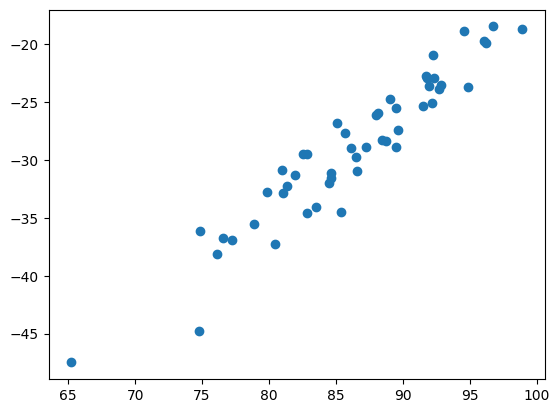

In [18]:
import matplotlib.pyplot as plt

plt.scatter(phScores, myScores)

From this graph, we can see our scores are quite well correlated with those of pyHMMER indicating that our models are quite similar